# Villin: mindist model

In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob
import math


from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print
from IPython.display import Markdown, display

## Define auxiliary functions

Here, we define a set of functions which will make plotting easier.

In [2]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def cca(traj_a, traj_b):
    def _isqrt(x):
        w, v = np.linalg.eigh(x)
        return np.dot(v, np.dot(np.diag(1.0 / np.sqrt(w)), v.T))
    return np.linalg.svd(
        np.dot(
            _isqrt(np.dot(traj_a.T, traj_a)),
            np.dot(
                np.dot(traj_a.T, traj_b),
                _isqrt(np.dot(traj_b.T, traj_b)))))

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

## Create a feature reader


In [3]:
path='/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein/'
trajs = '2F4K-0-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))]
pdb_file = path + 'villin.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
#features.add_residue_mindist()
features.add_backbone_torsions()
#features.add_minrmsd_to_ref(path + '2F4K-0-protein-000.dcd', ref_frame=9000)
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

## RMSD

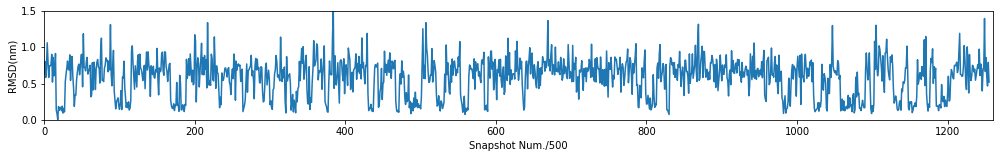

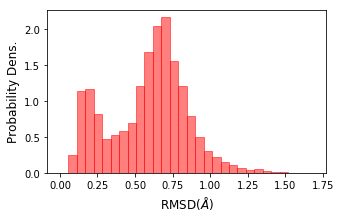

In [4]:
reference = md.load_dcd(path + '2F4K-0-protein-000.dcd', top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 1 to 33')

rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj, reference,9000, atom_indices=CA_atoms):
        rmsd.append(element)

fig = plt.figure(figsize = (17, 2))
plt.plot(rmsd[::500])
plt.axis([0, 1260, 0.0, 1.5])
plt.ylabel("RMSD(nm)")
plt.xlabel("Snapshot Num./500")
plt.show()


#histogram
fig =plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd[::100], normed=True, bins=30, color="r", alpha=0.5, edgecolor="r")
ax1.set_xlabel("RMSD$(\AA)$", fontsize=12)
ax1.set_ylabel("Probability Dens.", fontsize=12)

# to Angstrom
rmsd = np.array(rmsd) * 10.0

## Discretization

We need to increase the transformation lagtime and number of cluster centers to get a good ITS convergence.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

18-10-17 15:36:59 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


A Jupyter Widget

A Jupyter Widget

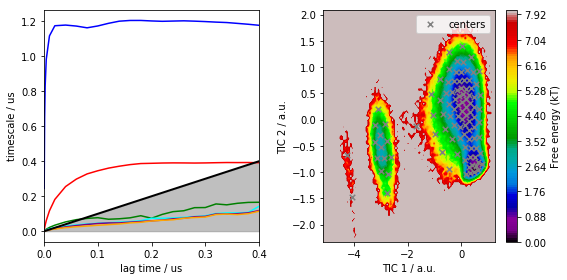

In [5]:
tica = pyemma.coordinates.tica(data=source, lag=500, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1], cmap=mpl.cm.nipy_spectral)
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

## MSM estimation and analysis

At $\tau=0.15\mu s$, the ITS are reasonably flat and we can build an MSM which passes the CK test using two metastable states.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 700 steps


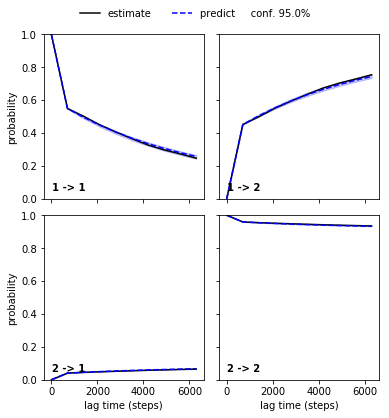

In [6]:
lag = get_lagtime_from_array(lags, 0.15, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PI = [0.058317614477806805, 0.94168238552219308]
MFPT[0, 1] = 1.331 us
MFPT[1, 0] = 21.274 us


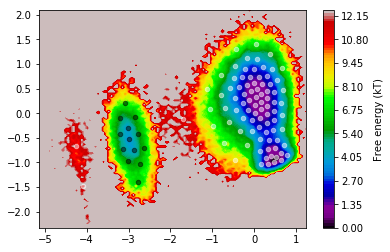

In [7]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us')
msm.pcca(2)
fig, ax = pyemma.plots.plot_free_energy(*tica.T, weights=msm.pi[cluster.dtrajs])
ax.scatter(*cluster.clustercenters[msm.metastable_sets[0], :].T, s=20, c='black', alpha=0.5)
ax.scatter(*cluster.clustercenters[msm.metastable_sets[1], :].T, s=20, c='white', alpha=0.5)
print('PI = ' + str([msm.pi[s].sum() for s in msm.metastable_sets]))
print('MFPT[0, 1] = %2.3f us' % msm.mfpt(msm.metastable_sets[0], msm.metastable_sets[1]))
print('MFPT[1, 0] = %2.3f us' % msm.mfpt(msm.metastable_sets[1], msm.metastable_sets[0]))

# PART 2:

## Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

We follow some rules to build (in every mergin step) a new set of transition probabilities $\{k_{i,j}\}$, defined with the same lag-time $\tau$. After merging two states $l$ and $m$, the probability of the transitions entering the new state that we will call "$lm$", from any state $i$, is computed as


$$k_{i,ml}=k_{i,m}+k_{i,l}$$


On the other hand the transition probabilities from $ml$ to any other state $j$ is computed as 


$$k_{ml,j}=\frac{p_m k_{m,j}+p_l k_{l,j}}{p_m+p_l}$$


Similarly,

$$k_{ml,ml}=\frac{p_m (k_{m,m}+k_{m,l})+p_l (k_{l,l}+k_{l,m})}{p_m+p_l}$$

IMPORTANT: The goal of this clusterig is tho identify macrostates and not to use the best lag-time, the lag-time use for clustering could different from the one that would be appropiate for the final Markov model.

### Lag times to use (only for clustering)

In [8]:
#lag_to_use = [1, 10, 100, 1000]
lag_to_use = [1]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# This are the t_cut intervals to explore (in lag-time units) with the lag times in "lag_to_use"
#range_per_lag = [[200,600], [200,350], [100,250], [30,200]]
#range_per_lag = [[362,377]]
range_per_lag = [[250,600]]

### The transition matrix

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


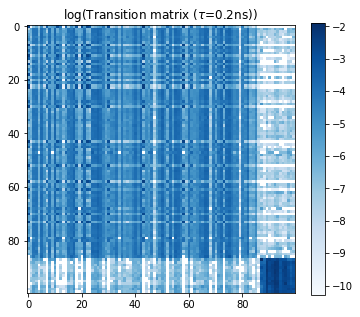

In [9]:
from sklearn.cluster import SpectralBiclustering
bic = SpectralBiclustering(2)
bic.fit(msm.P)

plt.figure(figsize=(6,5))
order = np.argsort(bic.column_labels_)

plt.imshow(np.log(msm.P[order][:,order]), cmap="Blues")
plt.colorbar()
plt.title(r"log(Transition matrix ($\tau$=0.2ns))")
plt.savefig('log-transition-matrix.jpg', dpi=300)

### The flux matrix

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


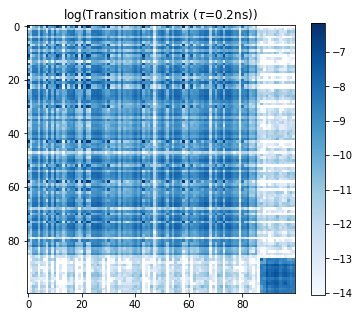

In [20]:
K = msm.P

n_states = len(K)

flux_matrix = np.zeros((n_states, n_states))

for i in range(n_states):
    for j in range(n_states):
        flux_matrix[i,j] = msm.pi[i] * K[i,j]


bic = SpectralBiclustering(2)
bic.fit(msm.P)

plt.figure(figsize=(6,5))
order = np.argsort(bic.column_labels_)

plt.imshow(np.log(flux_matrix[order][:,order]), cmap="Blues")
plt.colorbar()
plt.title(r"log(Transition matrix ($\tau$=0.2ns))")
plt.savefig('log-transition-matrix.jpg', dpi=300)
    

### The commute matrix

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


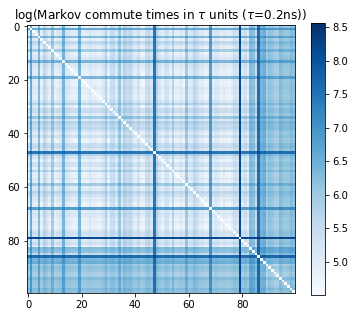

In [21]:
tij = mfpts_matrix(msm.P)+mfpts_matrix(msm.P).T ## round trip (commute) matrix

from sklearn.cluster import SpectralBiclustering
bic = SpectralBiclustering(2)
bic.fit(msm.P)

plt.figure(figsize=(6,5))
order = np.argsort(bic.column_labels_)

#plt.imshow(np.log(msm.P[order][:,order]), cmap="Blues")
plt.imshow(np.log(tij[order][:,order]), cmap="Blues")
plt.colorbar()
plt.title(r"log(Markov commute times in $\tau$ units ($\tau$=0.2ns))")
plt.savefig('log-transition-matrix.jpg', dpi=300)

### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 50.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns


/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 60.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 70.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 80.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 90.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 100.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 110.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 120.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 130.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 140.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 150.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 160.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 170.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 180.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns
t_cut: 190.00ns, t_min: 0.00ns, t_max: 0.00e+00ns, tAB: 23.68ns


#### Observed clusters vs t_cut

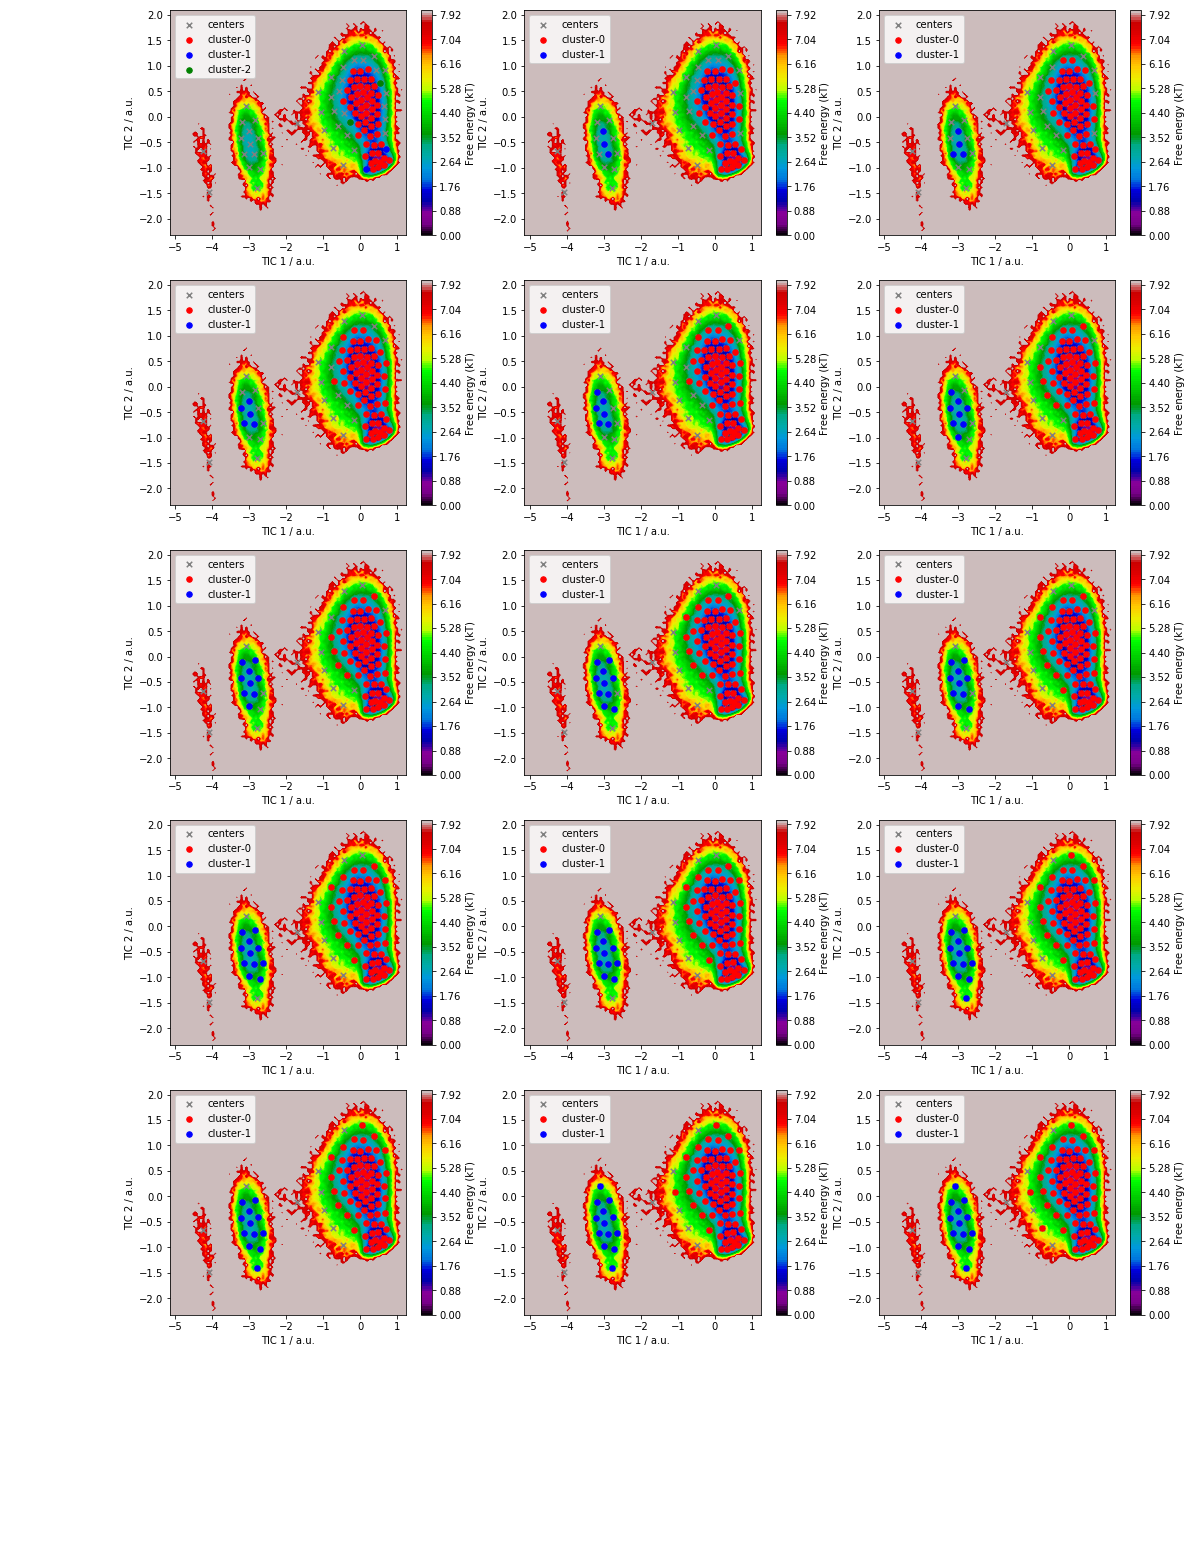

In [22]:
K = msm.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//15 
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

ini_clusters=None
for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    #clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)
    clusters = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False, ini_clusters=ini_clusters)

    t_min, t_max = 0, 0

    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))
    #print("Number of clusters: ", len(clusters))
    #print("Clusters size: ", [len(i) for i in clusters])
    #print(big_clusters)
    
    plt.subplot(fig_n_rows, fig_n_cols, ii+1)
    pyemma.plots.plot_free_energy(*tica.T)
    plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
    plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

    colors = ['red','blue','green','black','orange','magenta','tan','lime']

    for i, cluster_i in enumerate(big_clusters):
        cluster_i_tica_xy = []
        for index in cluster_i:
            cluster_i_tica_xy.append(cluster.clustercenters[index])
        cluster_i_tica_xy = np.array(cluster_i_tica_xy)
        plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

    plt.legend(loc='upper left')
    plt.xlabel('TIC 1 / a.u.')
    plt.ylabel('TIC 2 / a.u.')
    
    ini_clusters = clusters
printmd("#### Observed clusters vs t_cut")
plt.show()

# printmd("#### t_AB plots:")
# plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)